# Cell Communities exploration

In [46]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
from anndata import AnnData
from matplotlib import pyplot as plt
import skimage.measure
import os
import scipy.ndimage.measurements

In [47]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [48]:
RESULTS_PATH = 'C:/Users/mejas/Documents/BGI/probation/cellcommunities/results/'

In [49]:
# data_path = 'C:/Users/mejas/Documents/BGI/datasets/stereoseq/SS200000135TL_D1_with_annotation.h5ad'
# annotation_label = 'celltype_pred'
data_path = 'C:/Users/mejas/Documents/BGI/datasets/stereoseq/E16.5_E1S3_cell_bin_whole_brain_spagft_4.h5ad'
dataset_name = os.path.splitext(os.path.basename(data_path))[0]
annotation_label = 'sim anno'
# define if each cell type needs a minimum amount of cells to be considered in cell mixtures and what is the minimum value
min_count_per_type_limit = False
min_count_per_type = 100

adata = sc.read(data_path)

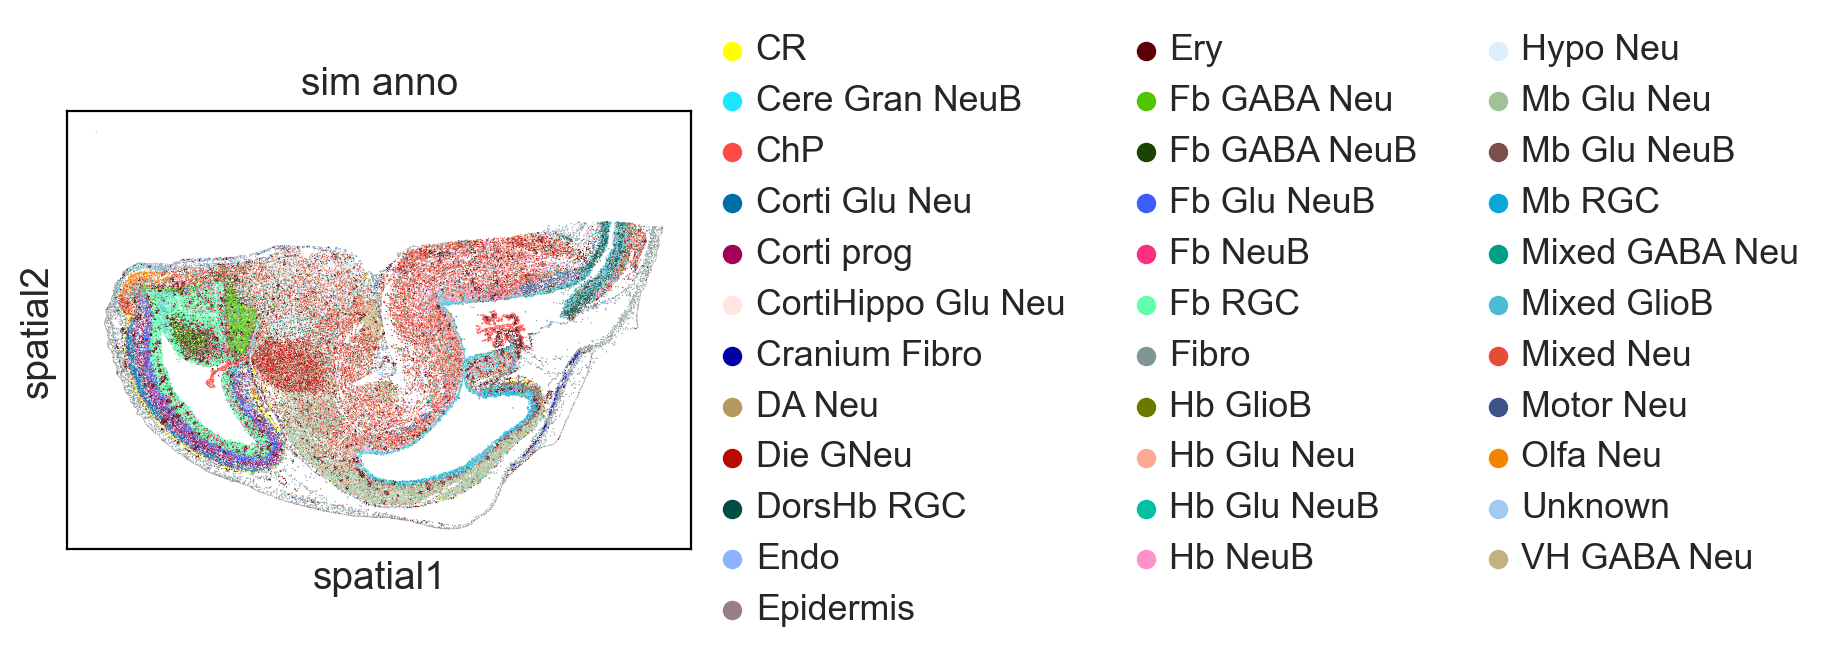

In [50]:
sc.pl.spatial(adata, color=annotation_label, palette=list(adata.uns[f'{annotation_label}_colors']), spot_size=30)

# Sliding window

In [51]:
def tissue_cluster(adata1, use_col, bin_size = 150,  moran_thres = -1, sliding_step = None, resolution=0.2, entropy_thres=0.0005, scat_thres=0.09):

    # create results folder
    dir_name = f'{dataset_name}_sws{bin_size}_ss{sliding_step}_ldr{resolution}_mrit{moran_thres}_entt{entropy_thres}_scatt{scat_thres}'
    dir_path = os.path.join(RESULTS_PATH, dir_name)
    file_extension = f'sws{bin_size}_ss{sliding_step}_ldr{resolution}_mrit{moran_thres}_entt{entropy_thres}_scatt{scat_thres}'
    if (not os.path.exists(dir_path)):
        os.mkdir(dir_path)

    # bin size needs to be a multiple of sliding step
    sliding_step = (bin_size/int((bin_size/sliding_step))) if sliding_step!=None else bin_size
    bin_slide_ratio = int(bin_size/sliding_step)

    # create centroids for each sliding step of windows
    adata1.obs['Centroid_X'] = ((adata1.obsm['spatial'][:,0])/sliding_step).astype(int)
    adata1.obs['Centroid_Y'] = ((adata1.obsm['spatial'][:,1])/sliding_step).astype(int)
    # need to understand borders and padding
    # subwindows belonging to borders will not have a complete cell count
    x_max = adata1.obs['Centroid_X'].max()
    y_max = adata1.obs['Centroid_Y'].max()
    x_min = adata1.obs['Centroid_X'].min()
    y_min = adata1.obs['Centroid_Y'].min()

    adata1.obs['x_y'] = adata1.obs['Centroid_X'].astype(str) +'_'+adata1.obs['Centroid_Y'].astype(str)
    tmp = adata1.obs[['x_y', use_col]]
    unique_cell_type = adata1.obs[use_col].cat.categories
    templete_dic = {ct:0 for ct in unique_cell_type}
    ret = {}
    # calculate features for each subwindow
    for sw_ind, sw_data in tmp.groupby('x_y'):
        templete_dic = {ct:0 for ct in unique_cell_type}
        for cell in sw_data[use_col]:
            templete_dic[cell]+=1
        ret[sw_ind] = templete_dic
    # merge features by windows
    feature_matrix = {}
    for subwindow in ret.keys():
        # index of window is in the top left corner of the whole window
        feature_matrix[subwindow] = {}
        x_curr = int(subwindow.split("_")[0])
        y_curr = int(subwindow.split("_")[1])
        # # count the number of subwindows participating in full window feature vec
        # num_subw = 0

        for slide_x in range(0, np.min([bin_slide_ratio, x_max-x_curr+1])):
            for slide_y in range(0, np.min([bin_slide_ratio, y_max-y_curr+1])):  # starts from 1 since values with coordinates (0,0) are already written by initializing with ret[subwindow]
                if (f'{x_curr + slide_x}_{y_curr + slide_y}') in ret.keys():
                    # num_subw += 1
                    feature_matrix[subwindow] = {k: 
                                                feature_matrix[subwindow].get(k, 0) + ret[f'{x_curr + slide_x}_{y_curr + slide_y}'].get(k, 0)
                                                for k in set(feature_matrix[subwindow]).union(ret[f'{x_curr + slide_x}_{y_curr + slide_y}'])}
        # # scale the feature values by the number of summed subwindows that form it (it could be useful as feature vector normalization)
        # feature_matrix[subwindow] = {k:feature_matrix[subwindow][k]/num_subw for k in feature_matrix[subwindow].keys()}
        
        # scale the feature vector by the total numer of cells in it
        norm_factor = 10000/sum(feature_matrix[subwindow].values())
        for k in feature_matrix[subwindow]:
            feature_matrix[subwindow][k] = int(feature_matrix[subwindow][k] * norm_factor)
            
    feature_matrix = pd.DataFrame(feature_matrix).T
    tissue = AnnData(feature_matrix, dtype=np.int64)
    tissue.obsm['spatial'] = np.array([[x.split('_')[0], x.split('_')[1]] for x in feature_matrix.index]).astype(int)

    # calculate metrics by which the cell types can be filtered out if they appear in most of the tissue
    # Moran's I
    sc.pp.neighbors(tissue, use_rep='spatial')
    tissue.var['moransI'] = sc.metrics.morans_i(tissue)


    # entropy & scatteredness
    adata1.obs['x_coor'] = (adata1.obsm['spatial'][:,0])
    adata1.obs['y_coor'] = (adata1.obsm['spatial'][:,1])
    cx_min = np.min(adata1.obs['x_coor'])
    cx_max = np.max(adata1.obs['x_coor'])
    cy_min = np.min(adata1.obs['y_coor'])
    cy_max = np.max(adata1.obs['y_coor'])
    downsample_rate = 80
    # dil_element = np.ones(shape=(16,16), dtype=np.float64)
    # cell_stats = adata1.obs[[use_col, 'x_coor', 'y_coor']]
    tissue.var['entropy'] = pd.Series(index=unique_cell_type, name='entropy', dtype=np.float64)
    tissue.var['scatteredness'] = pd.Series(index=unique_cell_type, name='scatteredness', dtype=np.float64)
    for cell_t in unique_cell_type:
    
        tissue_window = np.zeros(shape=(int(np.ceil((cx_max-cx_min+1)/downsample_rate)), int(np.ceil((cy_max-cy_min+1)/downsample_rate))), dtype=np.int8)
        tissue_window[((adata1.obs['x_coor'][adata1.obs[use_col] == cell_t] - cx_min)/downsample_rate).astype(int), ((adata1.obs['y_coor'][adata1.obs[use_col] == cell_t] - cy_min)/downsample_rate).astype(int)] = 1
        # tissue_window = dilation(tissue_window, dil_element)
        # [NOTE] this does not work, the image is too big. Instead of dilating the pixel we should downsample the image 30 times by placing
        # cells into positions that are rounded after dividing by 30
        plt.imsave(fname=os.path.join(dir_path, f'tissue_window_{cell_t}_{file_extension}.png'), arr=tissue_window, vmin=0, vmax=1, cmap='gray', dpi=250)
        tissue.var['entropy'].loc[cell_t] = skimage.measure.shannon_entropy(tissue_window)
        _, num_objects = scipy.ndimage.measurements.label(tissue_window, structure=None, output=None) # this assumes 4 neighbors connectivity
        # # idea for scatteredness was to compute the number of connected components and divide it with number of existing non-zero elements
        # # but this measure does not contain the information on percentage of non-zero elements in the matrix.
        # # thus we multiply it with non-zero percentage (num non-zero / total num) creating just this formula
        # # num_object/image.size
        # # max value is based on neighbors size (if 4 then 1/4, if 8, 1/8), min value is 0 if there are no non-zero elements
        tissue.var['scatteredness'].loc[cell_t] = num_objects/tissue_window.size *4

    # save metrics results in csv format
    # print(tissue.var[['moransI', 'entropy', 'scatteredness']])
    tissue.var[['moransI', 'entropy', 'scatteredness']].to_csv(f'spatial_metrics_{file_extension}.csv')

    var_use = tissue.var.loc[(tissue.var['moransI']>moran_thres) & (tissue.var['entropy']<entropy_thres) & (tissue.var['scatteredness']<scat_thres)].index
    tissue.raw = tissue
    tissue = tissue[:, var_use]

    # sc.pp.normalize_total(tissue, target_sum=1)
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue, resolution=resolution)

    # max voting on cluster labels
    # init the new obs column
    tissue.obs['leiden_refined'] = list('x' for x in range(len(tissue.obs.index)))
    for x_curr, y_curr in tissue.obsm['spatial']:
        # index of subwindow is in the top left corner of the whole window
        subwindow_labels = {}
        for slide_x in range(0, np.min([bin_slide_ratio, x_curr - x_min + 1])):
            for slide_y in range(0, np.min([bin_slide_ratio, y_curr - y_min + 1])):
                # check if location exist (spatial area is not complete)
                if (f'{x_curr - slide_x}_{y_curr - slide_y}') in tissue.obs.index:
                    new_value = tissue.obs.loc[f'{x_curr - slide_x}_{y_curr - slide_y}', 'leiden']
                    subwindow_labels[new_value] = subwindow_labels[new_value] + 1 if new_value in subwindow_labels.keys() else 1
        
        # max vote
        # max vote should be saved in a new obs column so that it does not have diagonal effect on
        # other labels during refinment
        tissue.obs['leiden_refined'][f'{x_curr}_{y_curr}'] = max(subwindow_labels, key=subwindow_labels.get)

    # save anndata file
    tissue.uns['win_size'] = bin_size
    tissue.uns['sliding_step'] = sliding_step
    tissue.uns['resolution'] = resolution
    tissue.uns['morans_thres'] = moran_thres
    tissue.uns['entropy_thres'] = entropy_thres
    tissue.uns['scatteredness_thres'] = scat_thres
    tissue.uns['params_extension'] = file_extension
    tissue.uns['results_dir'] = dir_path
    tissue.uns['params_extension'] = file_extension
    tissue.write_h5ad(os.path.join(dir_path, f'tissue_{dataset_name}__{file_extension}.h5ad'))
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    adata1.obs['tissue_sliding_leiden'] = list(tissue.obs.loc[adata1.obs['x_y'], 'leiden_refined'])

    return tissue

In [52]:
# define if only cell types with more than min_count_per_type cells are used for cell communities extraction
if min_count_per_type_limit:

    cell_over_limit = []
    for cell_tp in adata.obs[annotation_label].cat.categories:
        cell_num = sum(adata.obs[annotation_label]==cell_tp)
        if cell_num > min_count_per_type:
            cell_over_limit.append(cell_tp)

    adata = adata[adata.obs[annotation_label].isin(cell_over_limit),:]

In [54]:
tissue = tissue_cluster(adata1=adata, use_col=annotation_label, bin_size=150, moran_thres=-1, sliding_step=50, resolution=0.2, entropy_thres=1.0, scat_thres=0.09)

C:\Users\mejas\AppData\Local\Temp/ipykernel_2592/3182088894.py:91: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  _, num_objects = scipy.ndimage.measurements.label(tissue_window, structure=None, output=None) # this assumes 4 neighbors connectivity
C:\Users\mejas\AppData\Local\Temp/ipykernel_2592/3182088894.py:108: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sc.pp.neighbors(tissue, use_rep='X')
C:\Users\mejas\AppData\Local\Temp/ipykernel_2592/3182088894.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tissue.ob

In [55]:
tissue

AnnData object with n_obs × n_vars = 22513 × 33
    obs: 'leiden', 'leiden_refined'
    var: 'moransI', 'entropy', 'scatteredness'
    uns: 'neighbors', 'leiden', 'win_size', 'sliding_step', 'resolution', 'morans_thres', 'entropy_thres', 'scatteredness_thres', 'params_extension', 'results_dir'
    obsm: 'spatial'
    obsp: 'distances', 'connectivities'

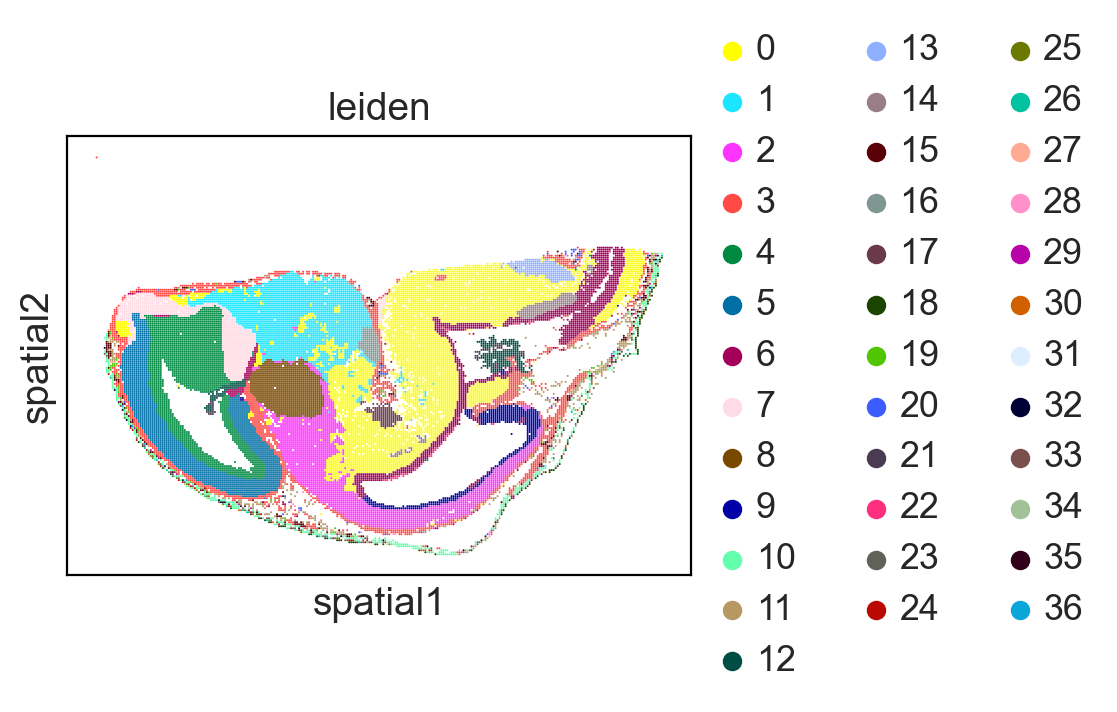

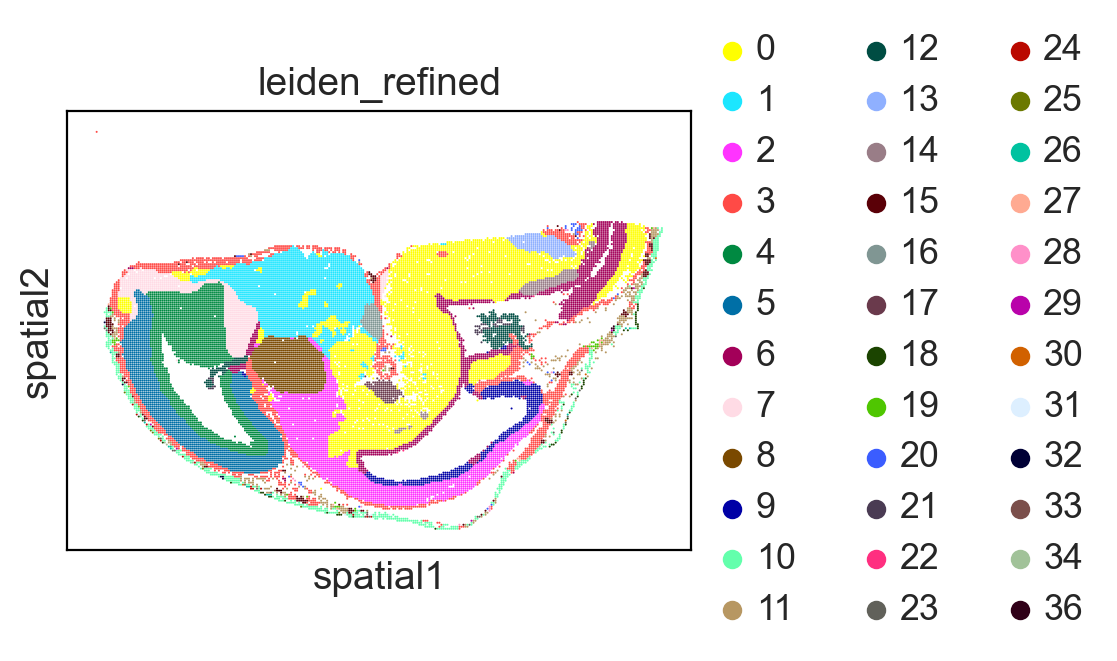

In [56]:
sc.settings.set_figure_params(dpi=100, facecolor='white')
# plot initial clustering for each window
sc.pl.spatial(tissue, color='leiden', spot_size=1)
# plot clustering after majority voting for each subwindow
sc.pl.spatial(tissue, color='leiden_refined', spot_size=1)

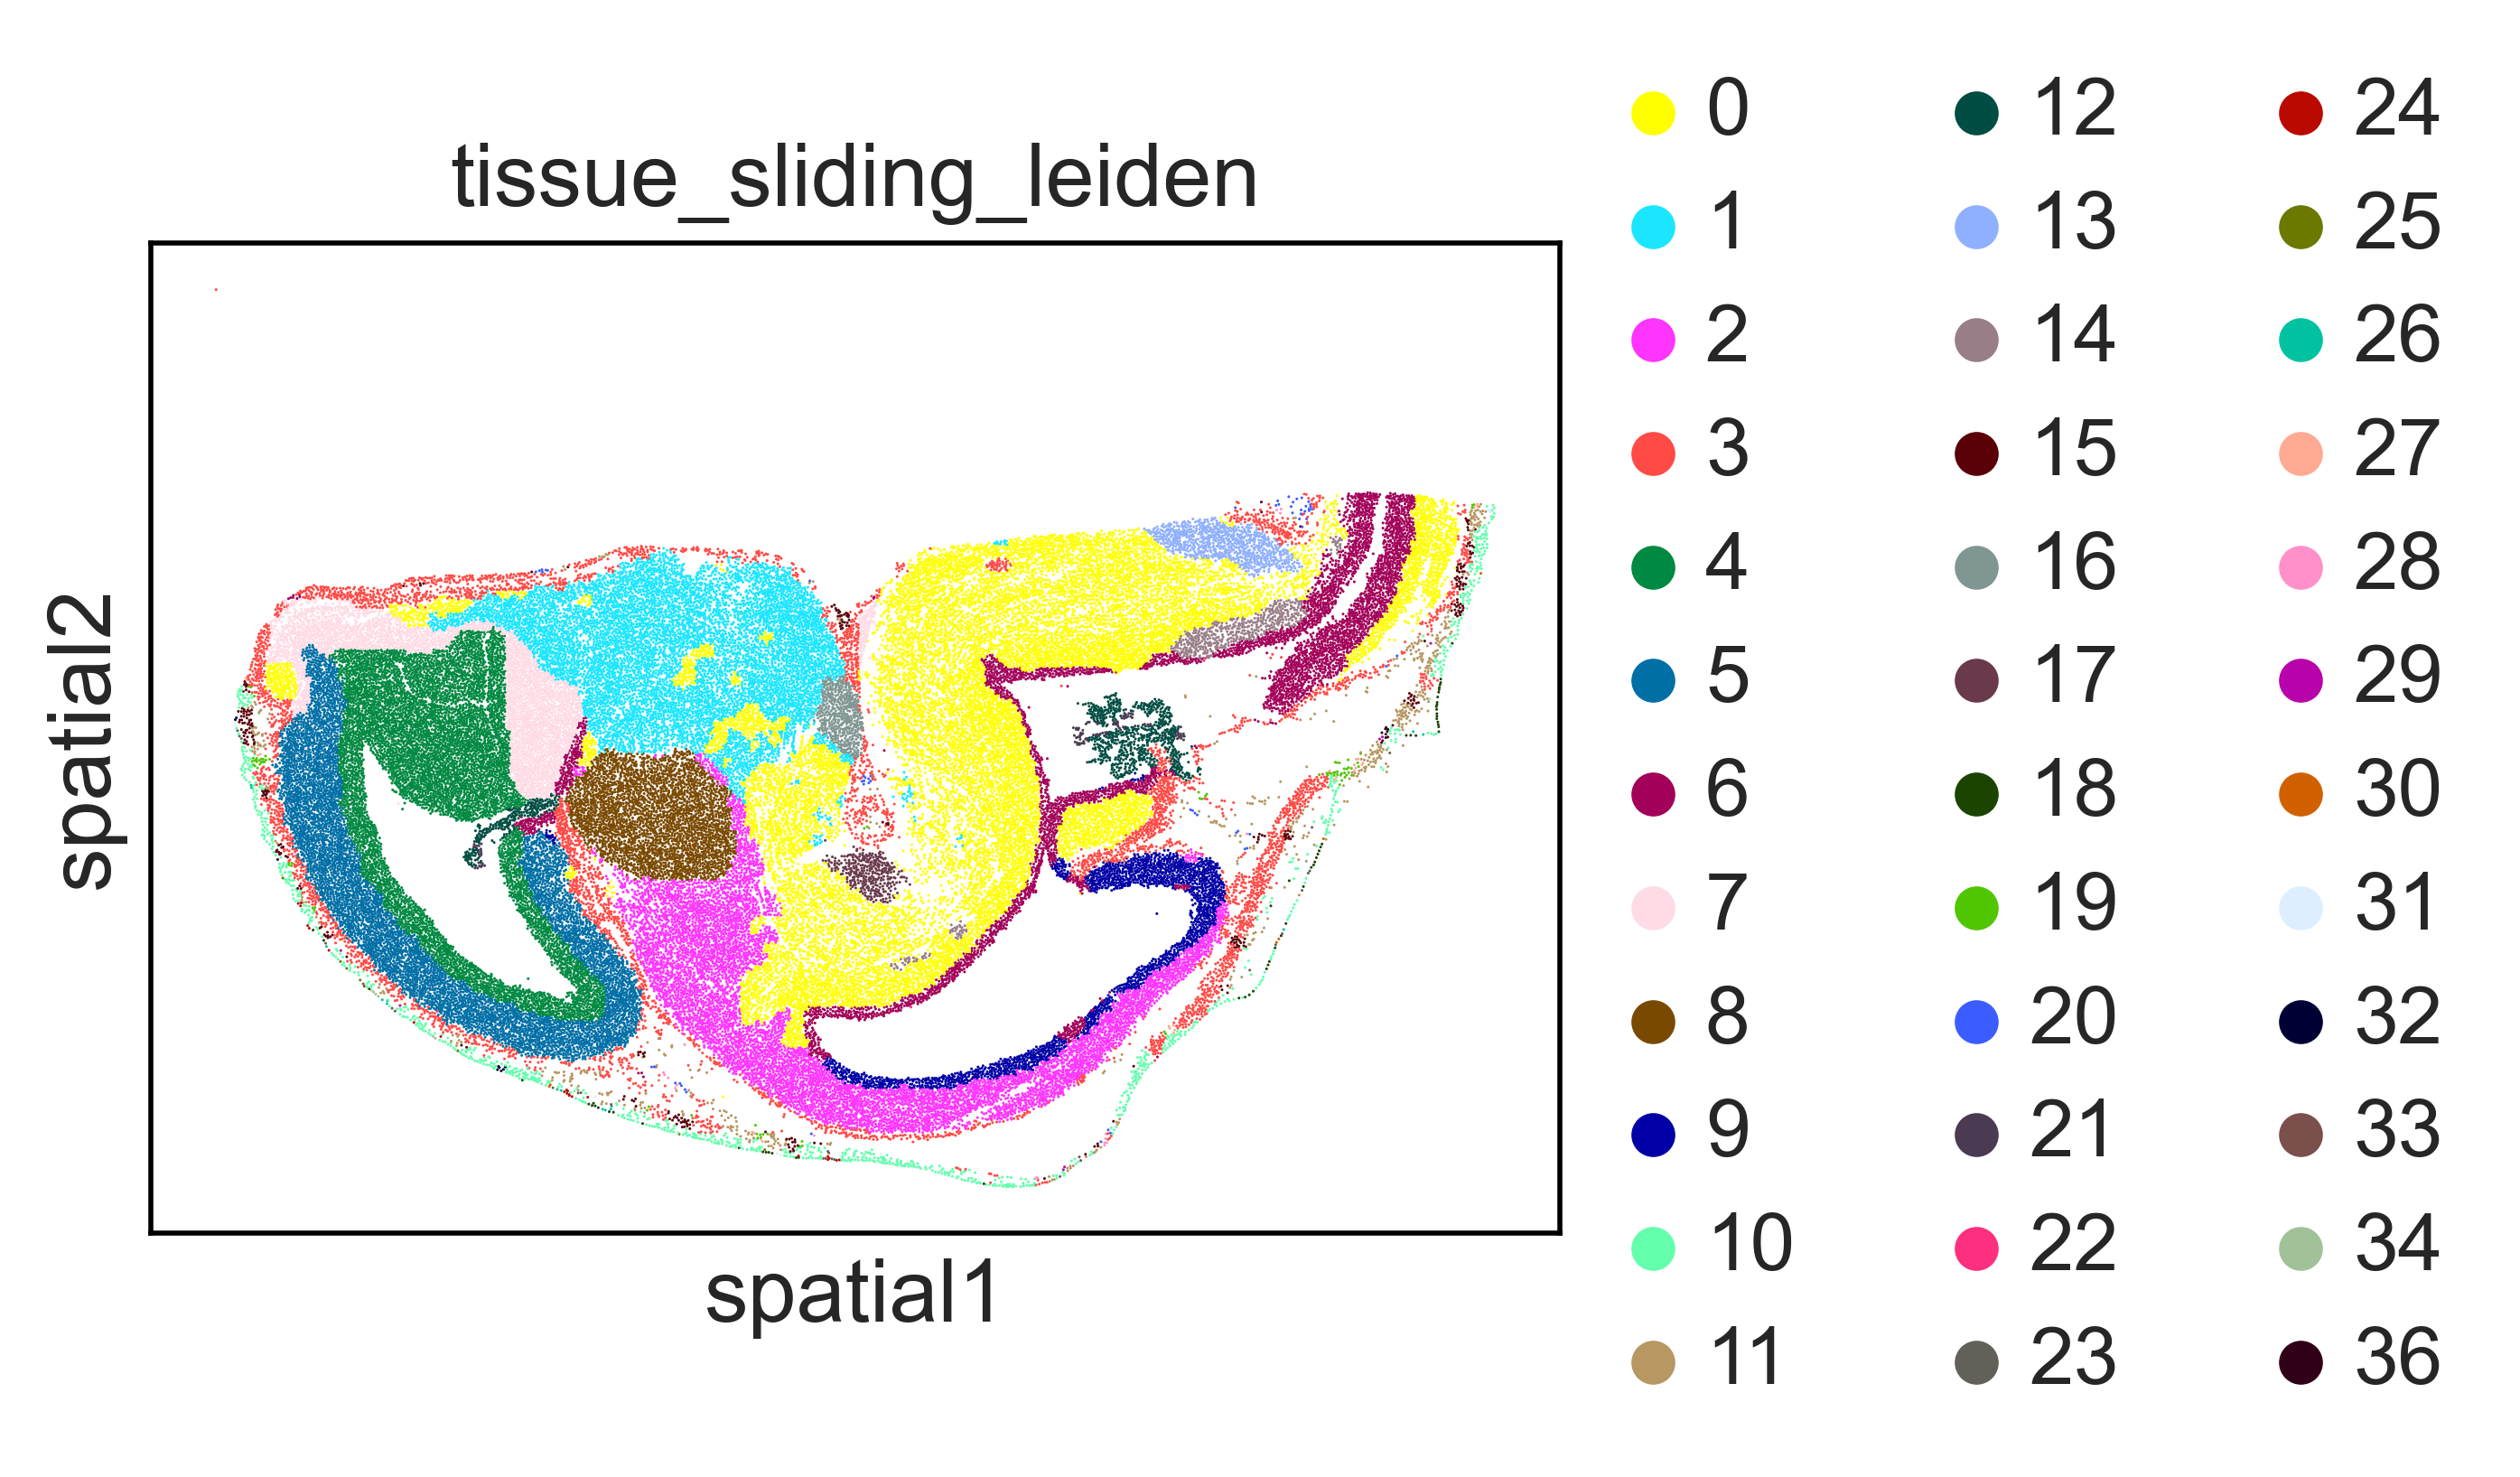

In [114]:
# plot final clustering in cell resolution
sc.settings.set_figure_params(dpi=250, facecolor='white')
sc.pl.spatial(adata, color='tissue_sliding_leiden', spot_size=30, show=False)
plt.savefig(os.path.join(tissue.uns['results_dir'], f'clusters_cellspots_{tissue.uns["params_extension"]}.png'), dpi=300, bbox_inches='tight')
plt.show()

## Cell community statistics

In [89]:
# extract information on leiden clustering labels and cell types to create cell communities statistics
clustering_labels = 'tissue_sliding_leiden'
cell_types_col = annotation_label
cell_types_communities = adata.obs[[clustering_labels, cell_types_col]]

stats_table = {}
# calculate cell type mixtures for every cluster
for label, cluster_data in cell_types_communities.groupby(clustering_labels):
    cell_type_dict = {ct:0 for ct in cell_types_communities[cell_types_col].cat.categories}
    for cell in cluster_data[cell_types_col]:
        cell_type_dict[cell]+=1
    # remove excluded cell types
    cell_type_dict = {k:cell_type_dict[k] for k in tissue.var.index}
    stats_table[label] = {k:cell_type_dict[k] for k in cell_type_dict}

    stats_table[label]['total_counts'] = int(sum(cell_type_dict.values()))


stats = pd.DataFrame(stats_table).T
# stats.index.name='clusters'
stats.columns.name="cell types"

# add final row with total counts per cell types
cell_type_counts = {ct:[int(sum(stats[ct].values))] for ct in tissue.var.index}
stats = pd.concat([stats, pd.DataFrame(cell_type_counts, index=['total_cells'])])

# divide each row with total sum of cells per cluster
for i in range(len(stats.index.values[:-1])):
    if stats.iloc[i,-1] > 0:
        stats.iloc[i, :-1] = (100 * stats.iloc[i, :-1] / stats.iloc[i, -1]).astype(int)
# save cell mixture statistics to csv file and to tissue
tissue.uns['cell mixtures'] = stats.iloc[:, :]
stats.to_csv(os.path.join(tissue.uns['results_dir'], f'cell_mixture_stats_{tissue.uns["params_extension"]}.csv'))

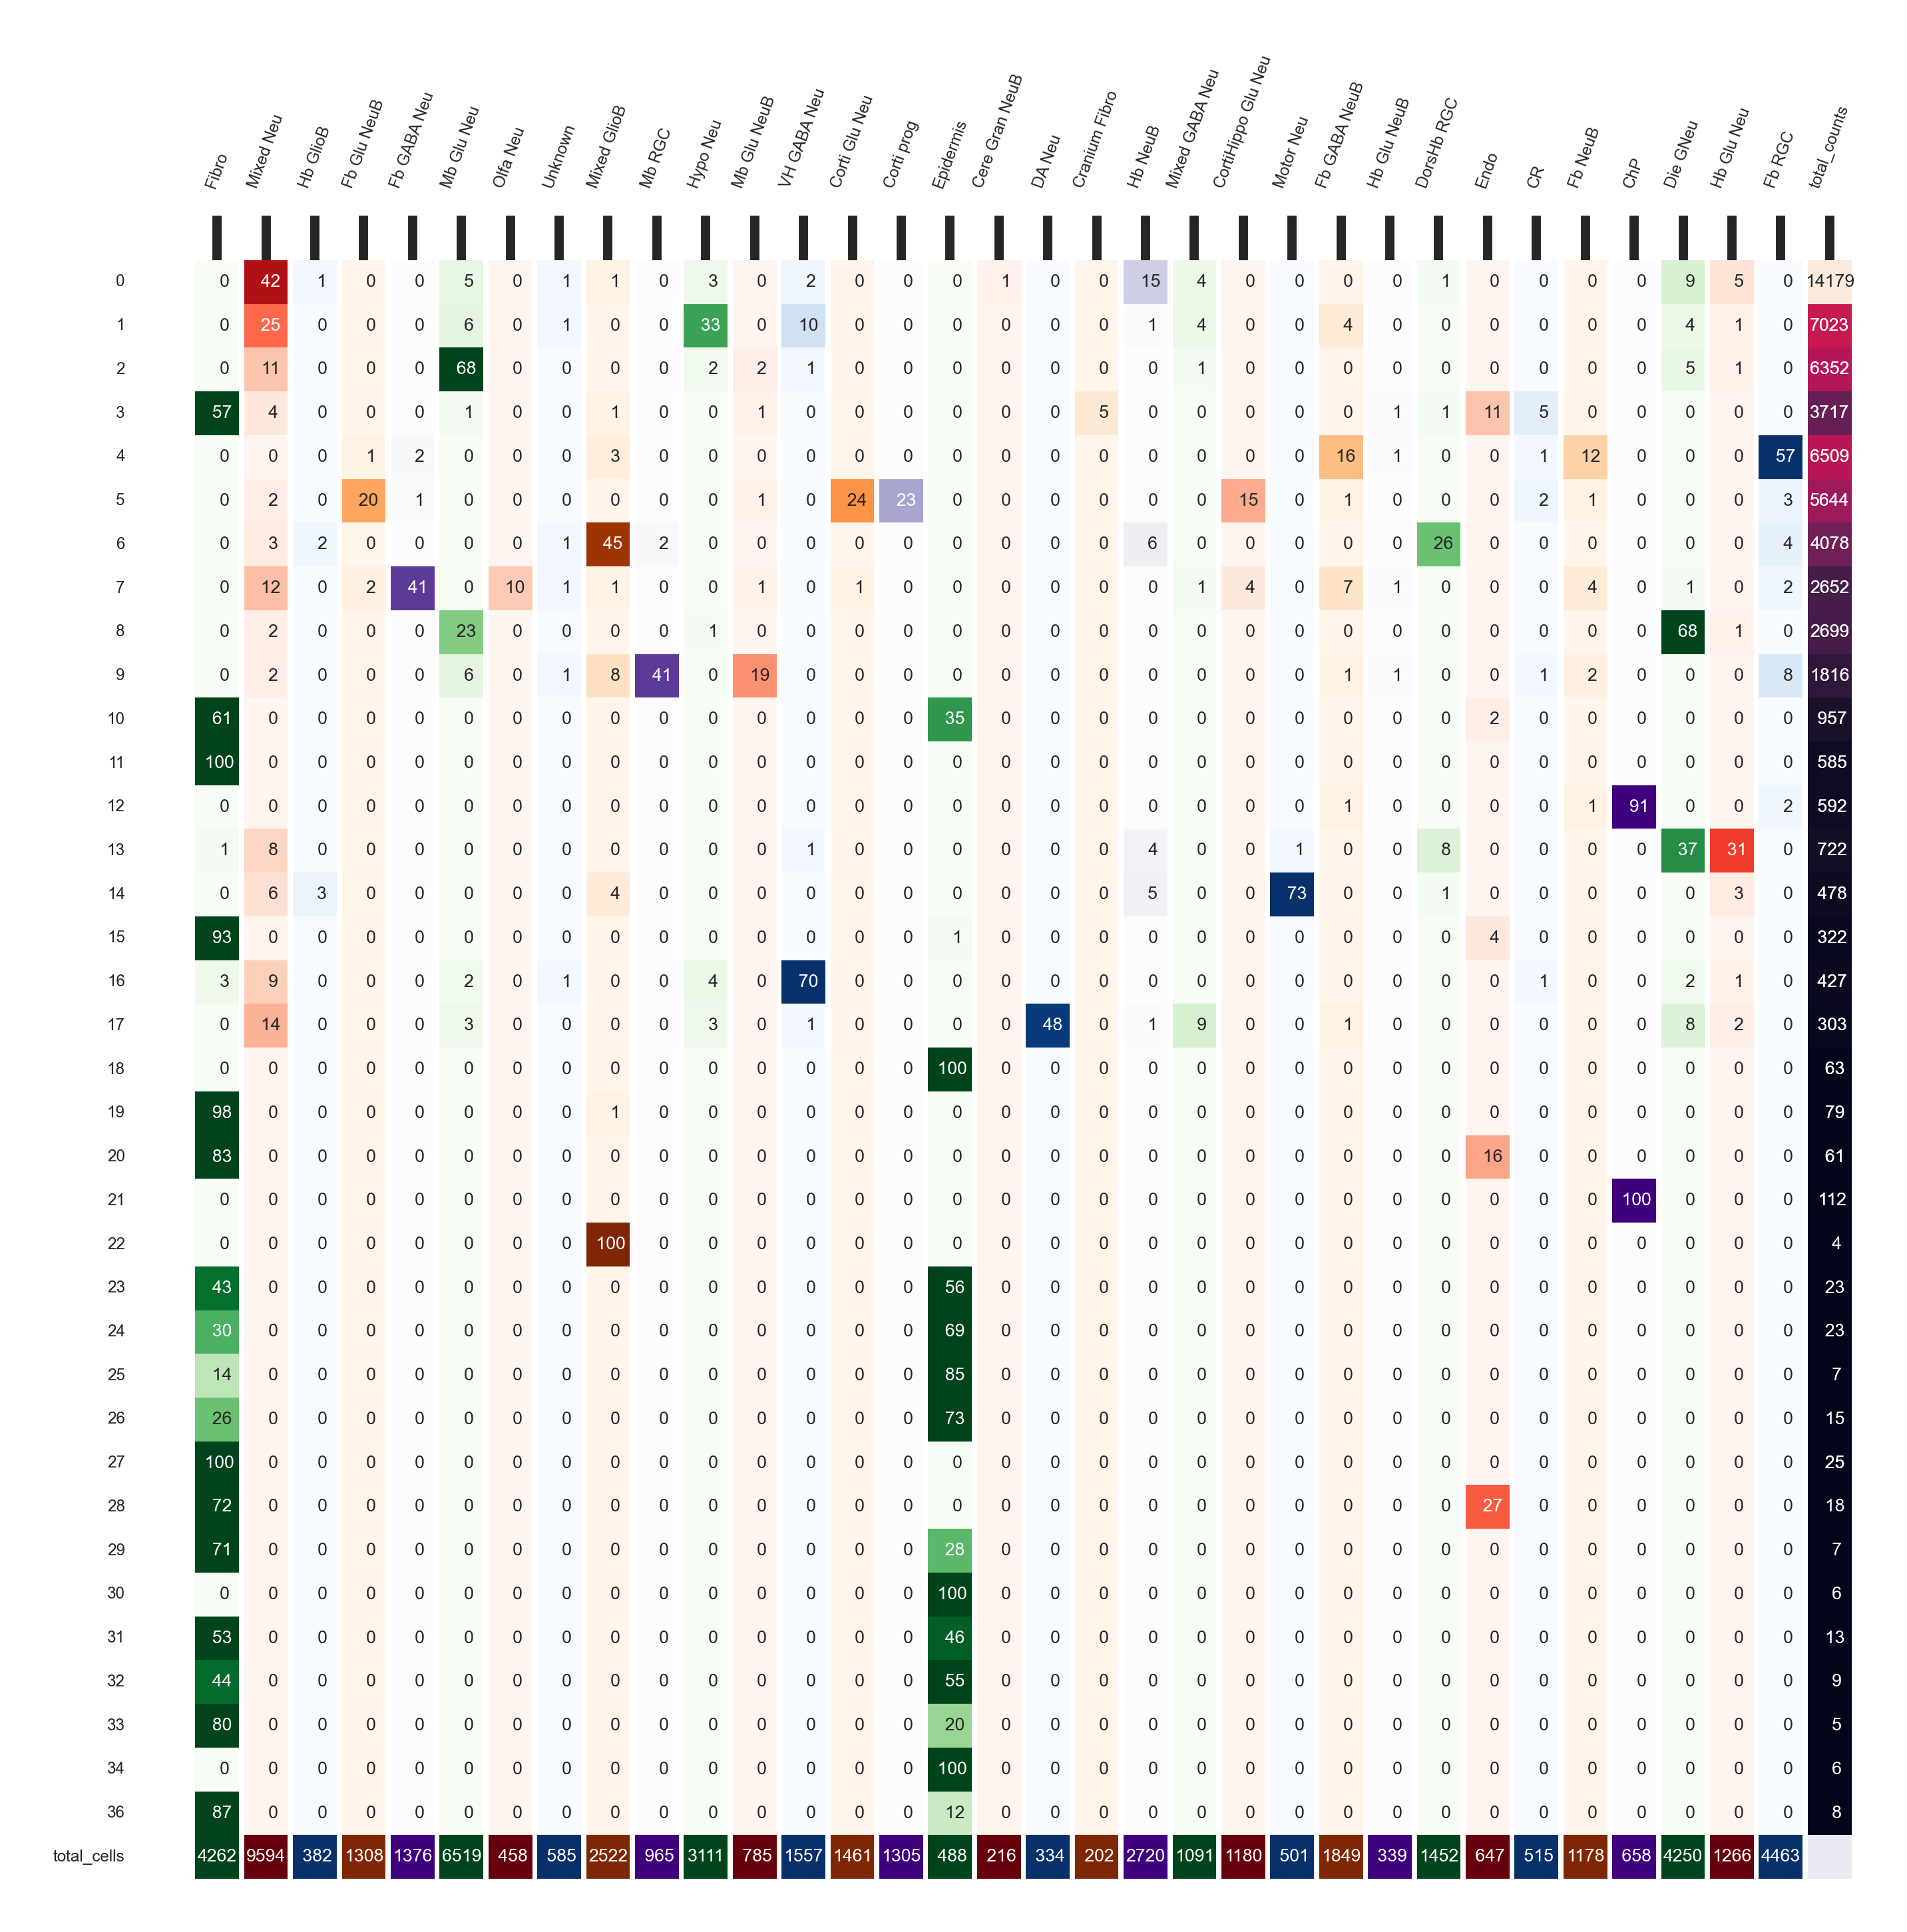

In [103]:
from matplotlib import pyplot as plt
from itertools import cycle
sc.settings.set_figure_params(dpi=400, facecolor='white')
sns.set(font_scale=0.2)

ncols = len(stats.columns) # we want to separately print the total_counts column
fig, axes = plt.subplots(ncols=ncols)

# no space between columns
fig.subplots_adjust(wspace=0)

# put colormaps of your choice in a list:
cmap_cycle = cycle(['Greens', 'Reds', 'Blues', 'Oranges', 'Purples'])

for i, ax in enumerate(axes):
    g = sns.heatmap(pd.DataFrame(stats.iloc[:, i]), vmin=0.0, vmax=50, linewidths=0, linecolor=None, annot=True, cbar=False, ax=ax, cmap=cmap_cycle.__next__(),fmt='4.0f', xticklabels=True, yticklabels=True if i==0 else False, square=True)
    g.set_xticklabels(g.get_xticklabels(), rotation=70)
    g.xaxis.tick_top() # x axis on top
# final column should have the sum of all cells per cluster
sns.heatmap(pd.DataFrame(stats.iloc[:, -1]), annot=True, linewidths=0, linecolor=None, cbar=False, cmap=None, ax=ax, fmt='4.0f', xticklabels=True, yticklabels=False, square=True)
plt.savefig(os.path.join(tissue.uns['results_dir'], f'cell_mixture_table_{tissue.uns["params_extension"]}.png'), dpi=400)
plt.show()

sc.settings.set_figure_params(dpi=100, facecolor='white')

## Automate the process of cluster extraction
### Find automatically clusters with more than 2 cell types having over [min_perc]% presence

In [115]:
min_cell_types = 2
min_perc = 20
min_perc_to_show = 5
min_cells_in_cluster = 500

In [125]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

new_stats = stats.copy()
new_stats = new_stats.drop(labels='total_counts', axis=1)
new_stats = new_stats.drop(labels='total_cells', axis=0)
for cluster in new_stats.iterrows():
    ct_perc = cluster[1].sort_values(ascending=False)
    if ct_perc[min_cell_types-1] > min_perc and stats.loc[cluster[0]]['total_counts']>min_cells_in_cluster:
        ct_ind = [x for x in ct_perc.index[ct_perc>min_perc_to_show]]
        
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
        # ax[0].legend([f'{ind} ({ct_perc[ind]})' for ind in ct_ind])
        sc.pl.spatial(adata, groups=ct_ind, color=annotation_label, spot_size=30, ax=ax[0], show=False)
        ax[0].legend([f'{ind} ({ct_perc[ind]})' for ind in ct_ind], bbox_to_anchor=(1.0, 0.5), loc='center left', frameon=False, fontsize=12)
        # new_legend = [f'{label._text} ({ct_perc[label._text]})' for label in g[0].legend().texts[:-1]]
        # g[0].legend(labels = new_legend.append('NA'))
        
        sc.pl.spatial(adata, groups=[cluster[0]], color='tissue_sliding_leiden', spot_size=30, ax=ax[1], show=False)
        fig.subplots_adjust(wspace=0.4)

        fig.savefig(os.path.join(tissue.uns['results_dir'], f'cmixtures_{tissue.uns["params_extension"]}_c{cluster[0]}.png'), bbox_inches='tight')

        plt.show()



C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


# Entropy, scatteredness and other metrics
### --evaluated on cell centered windows of different sizes--

In [ ]:
import skimage.measure
import scipy.stats
import scipy.ndimage.measurements

def metrics_calculator(stats, annot_col, cell_row, win_size):
    # make win_size odd
    win_size= win_size+1 if np.mod(win_size,2)==0 else win_size
    # init cell image to win_size square
    cell_image = np.zeros(shape=(win_size, win_size), dtype=np.int32)
    # define the shiftf relative to cell position in order to more easily fill the cell_image
    comp_X = cell_row['Centroid_X'] - (win_size-1)/2
    comp_Y = cell_row['Centroid_Y'] - (win_size-1)/2
    # fill the image with cells
    left    = cell_row['Centroid_X'] - (win_size-1)/2
    right   = cell_row['Centroid_X'] + (win_size-1)/2
    bottom  = cell_row['Centroid_Y'] - (win_size-1)/2
    top     = cell_row['Centroid_Y'] + (win_size-1)/2
    cell_window = stats[(stats['Centroid_X']<=right)&(left<=stats['Centroid_X'])&(stats['Centroid_Y']<=top)&(bottom<=stats['Centroid_Y'])]
    for _, cell_pos in cell_window.iterrows():
        cell_image[int(cell_pos['Centroid_X']-comp_X), int(cell_pos['Centroid_Y']-comp_Y)] = 1
    # calculate metrics
    entropy2D = skimage.measure.shannon_entropy(cell_image)
    entropy1D = scipy.stats.entropy(cell_image.ravel(), base=2)
    entropy1Dexp = scipy.stats.entropy(cell_image.ravel())
    _, num_objects = scipy.ndimage.measurements.label(cell_image, structure=None, output=None) # this assumes 4 neighbors connectivity
    # idea for scatteredness was to compute the number of connected components and divide it with number of existing non-zero elements
    # but this measure does not contain the information on percentage of non-zero elements in the matrix.
    # thus we multiply it with non-zero percentage (num non-zero / total num) creating just this formula
    # num_object/image.size
    # max value is based on neighbors size (if 4 then 1/4, if 8, 1/8), min value is 0 if there are no non-zero elements
    scatteredness = num_objects/cell_image.size *4

    return list([entropy2D, scatteredness, entropy1D, entropy1Dexp])

In [ ]:
def tissue_cluster_cell_res(adata1, use_col, win_size = 150, moran_thres = -1):
    adata1.obs['Centroid_X'] = (adata1.obsm['spatial'][:,0])
    adata1.obs['Centroid_Y'] = (adata1.obsm['spatial'][:,1])
    
    stats = adata1.obs[['Centroid_X', 'Centroid_Y', use_col]]
    stats[use_col].astype('category') 
    ret = []
    for row in stats.iterrows():
        # tmp = density_calculator(stats,use_col, row, bin_size/2, -1,1,1,-1)
        tmp = metrics_calculator(stats=stats, annot_col=use_col, cell_row=row[1], win_size=win_size)
        ret.append(tmp)
        
    ret = pd.DataFrame(ret)
    ret.index = adata1.obs_names
    ret.columns = ['entropy2D', 'scatteredness', 'entropy1Dbase2', 'entropy1Dbasee']
    # ret.columns = [stats[use_col].cat.categories]
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = adata1.obsm['spatial']
    

    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue, resolution=0.2)
    return tissue


In [ ]:
tissue = tissue_cluster_cell_res(adata, use_col=annotation_label, win_size = 100, moran_thres = -1)

C:\Users\mejas\AppData\Local\Temp/ipykernel_13220/3833960188.py:25: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  _, num_objects = scipy.ndimage.measurements.label(cell_image, structure=None, output=None) # this assumes 4 neighbors connectivity
C:\Users\mejas\AppData\Local\Temp/ipykernel_13220/2482845508.py:33: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tissue = AnnData(ret)


In [ ]:
tissue.var_names

Index(['entropy2D', 'scatteredness', 'entropy1Dbase2', 'entropy1Dbasee'], dtype='object')

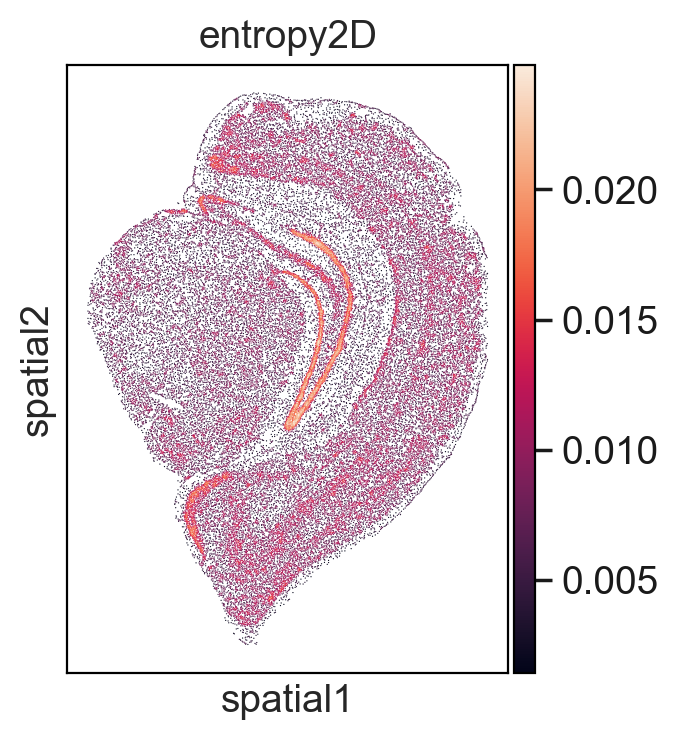

In [ ]:
sc.pl.spatial(tissue, color="entropy2D", spot_size=30)

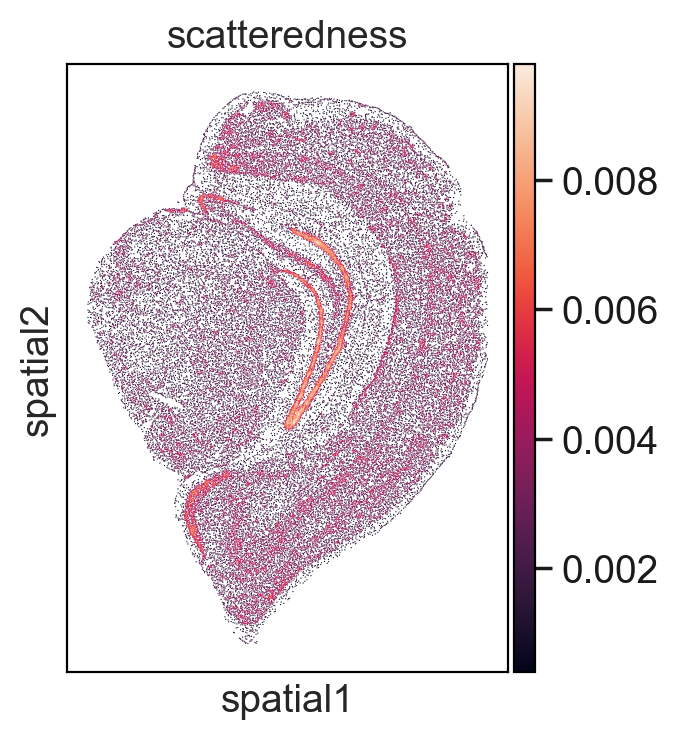

In [ ]:
sc.pl.spatial(tissue, color="scatteredness", spot_size=30)

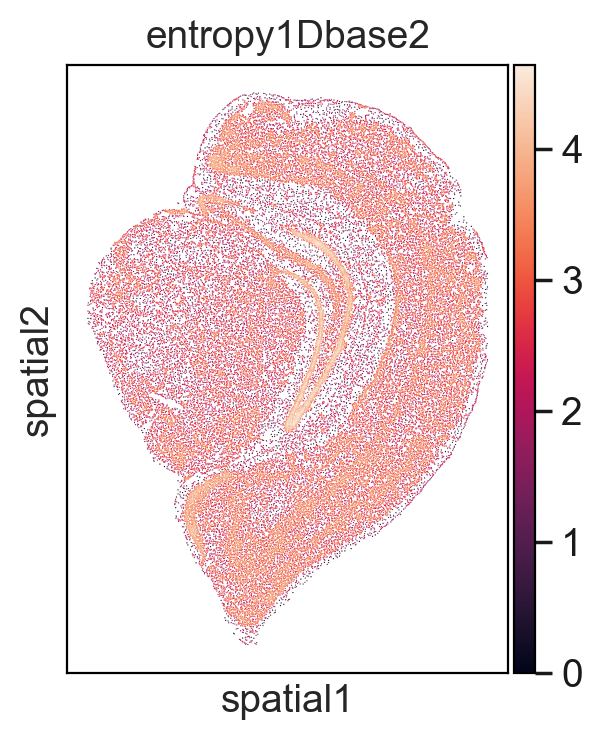

In [ ]:
sc.pl.spatial(tissue, color="entropy1Dbase2", spot_size=30)

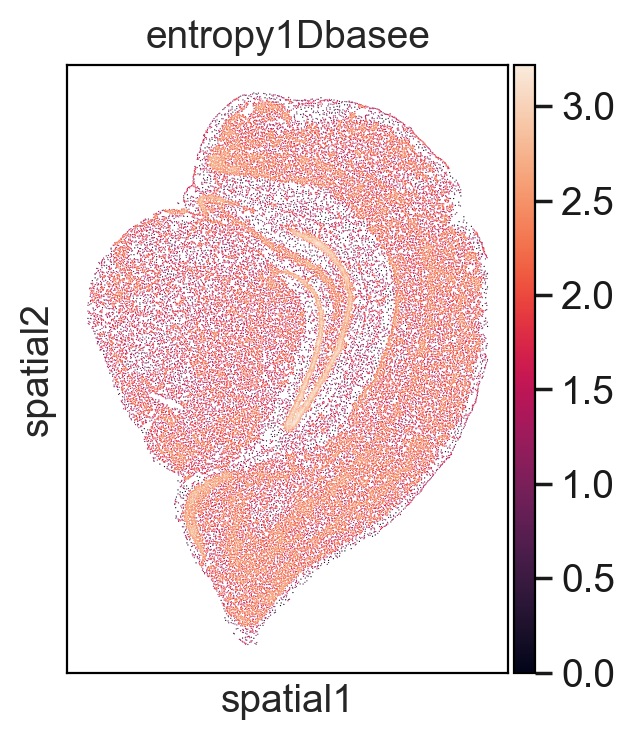

In [91]:
sc.pl.spatial(tissue, color="entropy1Dbasee", spot_size=30)

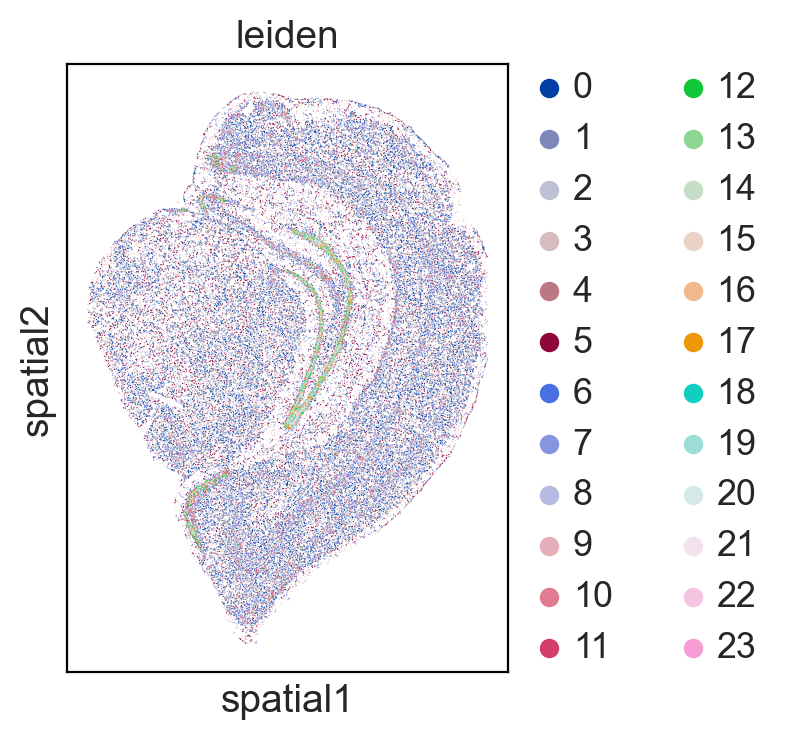

In [94]:
sc.pl.spatial(tissue, color="leiden", spot_size=30)

# Co-occurence max voting

In [8]:
# pd.options.mode.chained_assignment = None  # default='warn'

In [80]:
def density_calculator(stats, use_col, row, density_thred, l,r,u,d):
    left = row[1]['Centroid_X']+l*density_thred
    right = row[1]['Centroid_X']+r*density_thred
    up = row[1]['Centroid_Y']+u*density_thred
    down = row[1]['Centroid_Y']+d*density_thred
    #print(left, right, up, down)
    tmp = stats.loc[(stats['Centroid_X']<right)&(left<stats['Centroid_X'])&(stats['Centroid_Y']<up)&(down<stats['Centroid_Y'])]
    tmp = tmp.groupby(by=use_col).count()
    return list(tmp['Centroid_X'])
    

def tissue_max_voting_cluster_cell_res(adata1, use_col, win_size = 200, moran_thres = 0.0, resolution=0.2, vote_win_size=None):
    vote_win_size = win_size if vote_win_size==None else vote_win_size
    adata1.obs['Centroid_X'] = (adata1.obsm['spatial'][:,0])
    adata1.obs['Centroid_Y'] = (adata1.obsm['spatial'][:,1])
    
    stats = adata1.obs[['Centroid_X', 'Centroid_Y', use_col]]
    stats[use_col].astype('category') 
    ret = []
    for row in stats.iterrows():
        tmp = density_calculator(stats,use_col, row, win_size/2, -1,1,1,-1)
        # normalize cell count by total cell num
        tmp = tmp/np.sum(tmp)*1000
        ret.append(tmp.astype(int))
        
    ret = pd.DataFrame(ret)
    ret.index = adata1.obs_names
    ret.columns = stats[use_col].cat.categories
    tissue = AnnData(ret)
    tissue.obsm['spatial'] = adata1.obsm['spatial']
    
    # sc.pp.neighbors(tissue, use_rep='spatial')
    # tissue.var['moransI'] = sc.metrics.morans_i(tissue)
    # var_use = tissue.var.loc[tissue.var['moransI']>moran_thres].index
    # tissue.raw = tissue
    # tissue = tissue[:, var_use]
    sc.pp.neighbors(tissue, use_rep='X')
    sc.tl.leiden(tissue, resolution=resolution)
    #sc.pl.spatial(tissue, spot_size=1, color='leiden')
    #adata.obs['tissue_leiden']=list(tissue.obs.loc[adata.obs['x_y'], 'leiden'])


    # max voting on cluster labels
    # init the new obs column
    tissue.obs['leiden_refined'] = list('x' for x in range(len(tissue.obs.index)))
    for x_curr, y_curr in tissue.obsm['spatial']:
        # index of subwindow is in the center of the cell
        left    = x_curr - (vote_win_size-1)/2
        right   = x_curr + (vote_win_size-1)/2
        bottom  = y_curr - (vote_win_size-1)/2
        top     = y_curr + (vote_win_size-1)/2
        cell_window = tissue.obs['leiden'][(tissue.obsm['spatial'][:,0]<=right)&(left<=tissue.obsm['spatial'][:,0])&(tissue.obsm['spatial'][:,1]<=top)&(bottom<=tissue.obsm['spatial'][:,1])]
        # max vote
        # max vote should be saved in a new obs column so that it does not have ghost effect on
        # other labels during refinment
        tissue.obs.loc[(tissue.obsm['spatial'][:,0] == x_curr) & (tissue.obsm['spatial'][:,1] == y_curr), 'leiden_refined'] = cell_window.mode()[0]

    
    

    return tissue



In [81]:
tissue = tissue_max_voting_cluster_cell_res(adata, use_col=annotation_label, win_size = 150, moran_thres = -1, resolution = 0.005, vote_win_size = 50)

In [82]:
diverging_color_palette = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4','#762a83','#af8dc3','#e7d4e8','#d9f0d3','#7fbf7b','#1b7837', '#8c510a','#d8b365','#f6e8c3','#c7eae5','#5ab4ac','#01665e', '#b2182b','#ef8a62','#fddbc7','#e0e0e0','#999999','#4d4d4d'] 

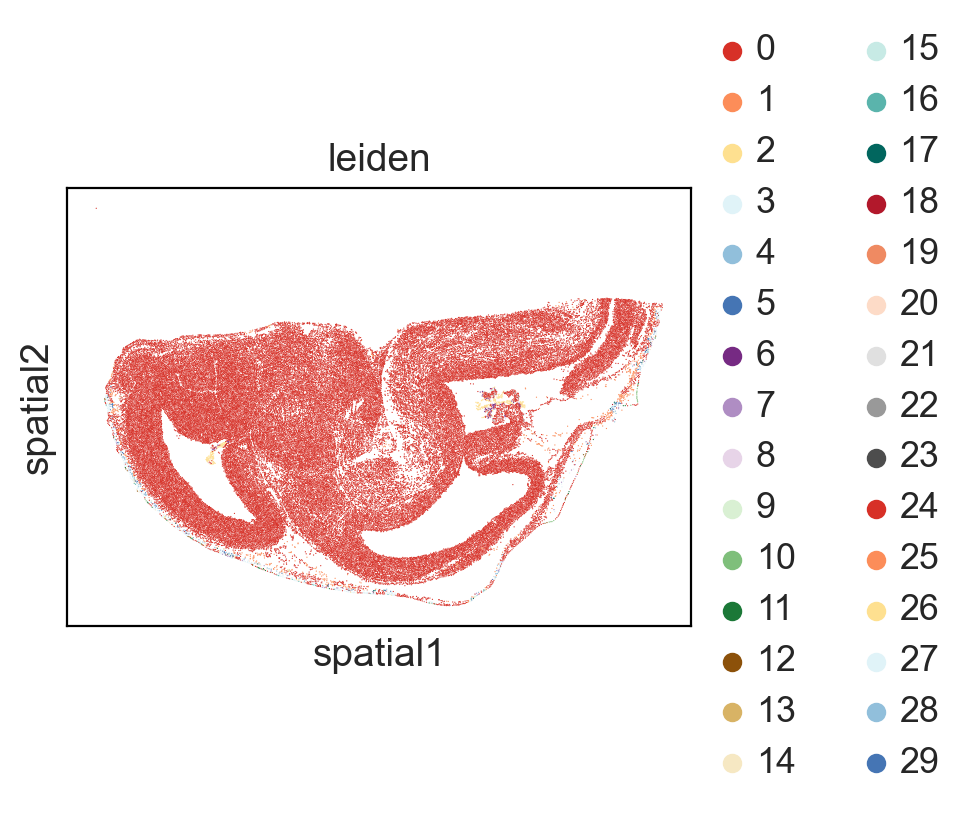

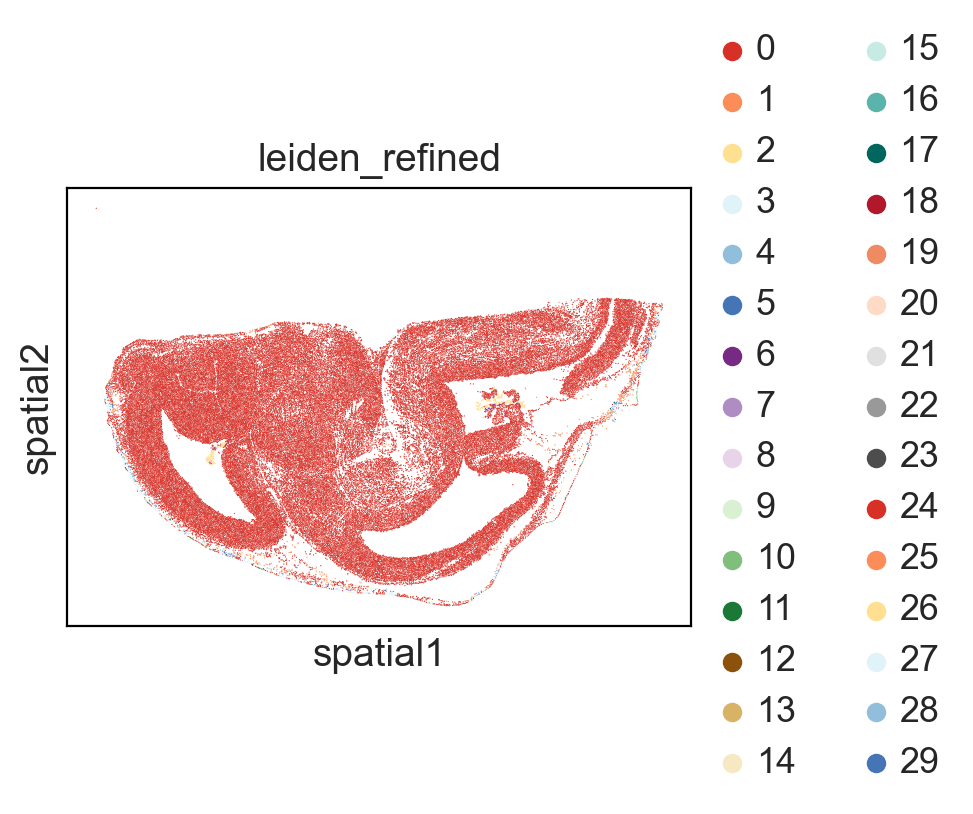

In [83]:
sc.pl.spatial(tissue, color='leiden', palette=diverging_color_palette, spot_size=30)
# plot clustering after majority voting for each subwindow
sc.pl.spatial(tissue, color='leiden_refined', palette=diverging_color_palette, spot_size=30)

In [84]:
adata.obs['tissue_sliding_leiden'] = tissue.obs['leiden_refined']

C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
C:\Users\mejas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scanpy\plotting\_tools\scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


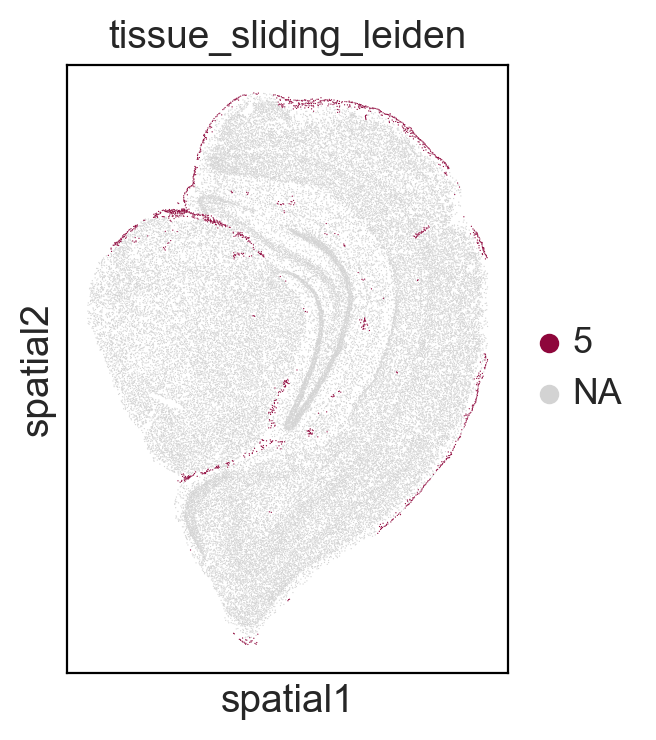

In [43]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

sc.pl.spatial(adata, groups=['5'], color='tissue_sliding_leiden', spot_size=30)